<a href="https://colab.research.google.com/github/kinzahassan15/ADS-Assignment-2/blob/main/MSCPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  /content/drive/MyDrive/msc_datasets.zip -d ./datasets

Streaming output truncated to the last 5000 lines.
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900065.txt  
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900072.txt  
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900073.txt  
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900074.txt  
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900075.txt  
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900076.txt  
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900077.txt  
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900078.txt  
  inflating: ./datasets/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1/111900079.t

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Corrected directory containing images
# image_dir = 'Small_dataset/Small_dataset/Images - 1/Images - 1'
image_dir = './datasets/Images - 1/Images - 1'

In [ ]:
# Function to load and preprocess all images from a directory
def load_and_preprocess_images(directory, target_size=(224, 224)):
    images = []
    labels = []
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            image = cv2.imread(img_path)
            if image is not None:
                # Resize the image to the target size
                image_resized = cv2.resize(image, target_size)
                images.append(image_resized)
                # Assuming the class label is part of the filename, e.g., 'class1_image1.jpg'
                label = filename.split('_')[0]
                labels.append(label)
    return images, labels

100%|██████████| 4000/4000 [02:51<00:00, 23.34it/s]


Loaded 4000 images
(4000, 224, 224, 3)
(4000,)


In [ ]:
# Load and preprocess images and labels
images, labels = load_and_preprocess_images(image_dir)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print('Loaded', len(images), 'images')
print(images.shape)
print(labels.shape)

In [ ]:
# Check the shapes of the images in the dataset
image_shapes = [img.shape for img in images]
unique_shapes = set(image_shapes)
print('Unique image shapes:', unique_shapes)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Create the ResNet model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(len(np.unique(labels_encoded)), activation='softmax')(x)

# Create the final model
model = tf.keras.models.Model(inputs=resnet_model.input, outputs=predictions)

# Freeze the layers of ResNet
for layer in resnet_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Unique image shapes: {(224, 224, 3)}
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
100/100 [==============================] - 42s 349ms/step - loss: 8.3546 - accuracy: 0.0000e+00 - val_loss: 8.3388 - val_accuracy: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 33s 334ms/step - loss: 8.2783 - accuracy: 0.0000e+00 - val_loss: 8.4186 - val_accuracy: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 33s 333ms/step - loss: 8.2615 - accuracy: 0.0000e+00 - val_loss: 8.4962 - val_accuracy: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 34s 335ms/step - loss: 8.2468 - accuracy: 0.0000e+00 - val_loss: 8.5719 - val_accuracy: 0.0000e+00
Epoch 5/50
100/100 [==============================] - 33s 333ms/step - loss: 8.2333 - accuracy: 0.0000e+00 - val_loss: 8.6459 - val_accuracy: 0.0000e+00
Epoch 6/50
25/25 [==============================] - 1s 52ms/step - loss: 8.3388 - accuracy: 0.0000e+00
Test loss: 8.338766098022461
T

In [ ]:
# Check the number of unique labels and their corresponding names
unique_labels = np.unique(labels_encoded)
print('Unique labels:', unique_labels)
print('Label names:', label_encoder.classes_)

# Check if the number of unique labels matches the number of target names
if len(unique_labels) != len(label_encoder.classes_):
    print('Mismatch in number of classes and target names.')
    print('Number of classes:', len(unique_labels))
    print('Number of target names:', len(label_encoder.classes_))
else:
    print('Number of classes and target names match.')

Unique labels: [   0    1    2 ... 3997 3998 3999]
Label names: ['100000000.jpg' '100000001.jpg' '100000002.jpg' ... '99900082.jpg'
 '99900083.jpg' '99900084.jpg']
Number of classes and target names match.


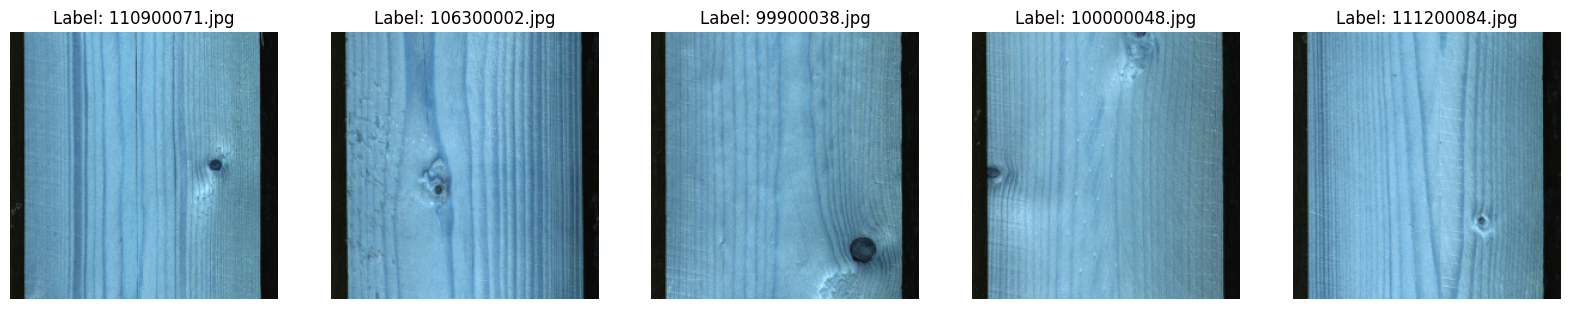

In [ ]:
# Display the first few labels and their corresponding images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title('Label: ' + str(labels[i]))
    ax.axis('off')
plt.show()

In [1]:
# Investigate the mismatch between the number of classes and target names
print('Number of classes:', len(np.unique(labels_encoded)))
print('Number of target names:', len(label_encoder.classes_))

# Display the unique labels and their corresponding target names
print('Unique labels:', np.unique(labels_encoded))
print('Target names:', label_encoder.classes_)

# Check if the labels in the dataset match the encoded labels
print('Dataset labels:', labels)
print('Encoded labels:', labels_encoded)